# Personalizing news content using Contextual Bandits

In the [Contextual Bandit(CB) introduction tutorial](https://cheng-tan.github.io/guides/contextual_bandits.html), we learnt about CB and different CB algorithms. In this tutorial we will mimic the scenario of personalizing news content on a site, using CB, to web users. The goal is to maximize user engagement quantified by measuring click through rate (ctr).

Let's recall that a CB setting has four components: 

- context
- action
- probability of choosing action
- reward/cost for chosen action

We want to maximize reward (ctr) or minimize loss (-ctr)

- We have two website visitors: 'Tom' and 'Anna'
- They visit the website at two different times in a day: 'morning' and 'afternoon'

The **context** is therefore (user, time_of_day)

We have the option of recommending a variety of articles to Tom and Anna

Therefore, **actions** are the different choices of articles: "politics", "sports", "music", "food", "finance", "health", "cheese"

The **reward** is whether they click on the article or not: 'click' or 'no click'

In the real world, we will have to learn Tom and Anna's preferences for articles i.e. the "reward function". Since this is a simulation we will define a reward function and see if the learner can optimize towards the reward function as we see more samples.

We will also modify the reward function in a few different ways and see if the CB learner picks up the changes. We will compare the CTR with and without learning.

Let's first start with importing the necessary packages. If you haven't installed vowpalwabbit, the easiest way to install it is to run 

- pip install vowpalwabbit

Note: You will need 64 bit Python

In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

# Reward function

In [2]:
# VW tries to minimize loss/cost, hence we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

The reward function below specifies that Tom likes to read articles related to politics in the morning and articles related to music in the afternoon where as Anna likes to read articles related to sports in the morning articles related to politics in the afternoon. If the learner recommends an article that aligns with the reward function, we give a positive reward i.e. click

In [3]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

# Understanding VW format

In [13]:
# This function modifies (context, action, cost, probablity) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [5]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared | user=Tom time_of_day=morning
| article=politics 
| article=sports 
| article=music 
| article=food 


In [ ]:
# explain the format above

# Getting an article/action recommendation

In [6]:
# This function .....
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [7]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

# Simulation set up

Now that we have defined a reward function and we know how to get actions to recommend to Tom and Anna, all we have to do si simulate Tom and Anna visiting the website. We will choose between Tom and Anna uniformly at random and also choose their time of visit uniformly at random. You can think of this as us tossig a coin to choose between Tom and Anna (Anna if heads and Tom if tails) and another coin toss for choosing time of day.

In [8]:
def choose_user(users):
    return random.choice(users)

In [9]:
def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

We will initialize the CB learner in VW and then simulate their website visits _num_sims_ number of times. In each visit, we:

- decide between Tom and Anna
- decide time of day
- pass context i.e. (user, time of day) to learner to get action i.e. article recommendation and probability of choosing action
- receive reward i.e. see if user clicked or not 
- format context, action, probablity, reward in VW format
- learn from the example

We will also explore three different scenarios that could happen in the real world

# Scenario 1

We will use the first reward function _get_cost_ and assume that Tom and Anna do not change their preferences over time and see what happens to user engagement as we learn

In [17]:
# initialize learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2 --random_seed 30")
# initialize users
users = ['Tom', 'Anna']
# initialize times of day
times_of_day = ['morning', 'afternoon']
# initialize list of actions
actions = ["politics", "sports", "music", "food", "finance", "health", "cheese"]

# only use first reward function
cost_sum = 0.
ctr = [] # variable to track running CTR
num_sims = 10000 # number of simulations to run
for i in range(1,num_sims):
    user = choose_user(users) # in each simulation choose a user 
    time_of_day = choose_time_of_day(times_of_day) # choose time of day for a given user
    context = {'user': user, 'time_of_day': time_of_day}
    action, prob = get_action(vw, context, actions)
    cost = get_cost(context, action)
    cost_sum += cost
    vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
    #vw.learn(vw_format)
    ctr.append(-1*cost_sum/i)

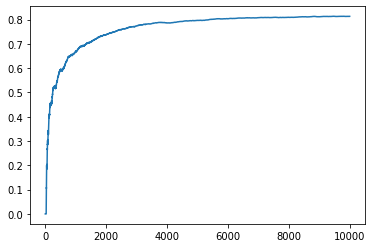

In [15]:
# with learning
plt.plot(range(1,num_sims), ctr)

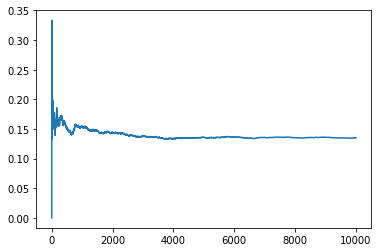

In [18]:
# without learning
# comment vw.learn in for loop
plt.plot(range(1,num_sims), ctr)

# Scenario 2

Let's say that at some point elections happened and Tom and Anna changed their preferences. This reward function below specifies that Tom likes to read articles related to politics in the morning and articles related to sports in the afternoon where as Anna likes to read articles related to politics in the morning and in the afternoon This reward function is still working with actions that the learner has seen previously.

In [19]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

Let us now switch to the second reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of the web users but it is still working with the same action space as before. We should see the learner pick up these changes and optimize towards the new preferences

In [25]:
# use first reward function initially and then switch to second reward function

cost_sum = 0.
ctr = []
num_sims = 1000
for i in range(1,num_sims):
    user = choose_user(users)
    time_of_day = choose_time_of_day(times_of_day)
    context = {'user': user, 'time_of_day': time_of_day}
    action, prob = get_action(vw, context, actions)
    cost = get_cost(context, action)
    cost_sum += cost
    vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
    #vw.learn(vw_format)
    ctr.append(-1*cost_sum/i)
for j in range(num_sims, 2* num_sims):
    user = choose_user(users)
    time_of_day = choose_time_of_day(times_of_day)
    context = {'user': user, 'time_of_day': time_of_day}
    action, prob = get_action(vw, context, actions)
    cost = get_cost_new1(context, action)
    cost_sum += cost
    vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
    #vw.learn(vw_format)
    ctr.append(-1*cost_sum/j)

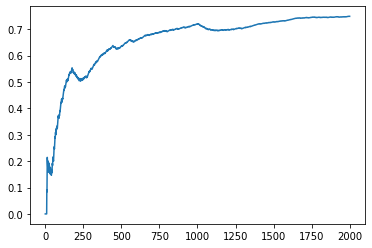

In [24]:
# with learning
plt.plot(range(1,2*num_sims), ctr)

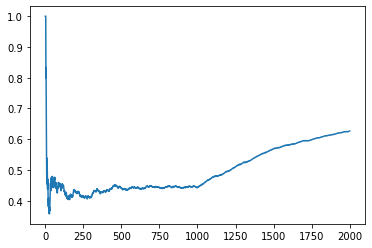

In [26]:
# without learning
# comment vw.learn in both for loops
plt.plot(range(1,2*num_sims), ctr)

# Scenario 3

Let's say that at some point a food festival happened and Tom and Anna changed their preferences. This reward function below specifies that Tom likes to read articles related to politics in the morning and articles related to food in the afternoon where as Anna likes to read articles related to food in the morning and in the afternoon. This reward function is now rewarding new actions i.e. actions that the learner hasn't seen so far.

In [4]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

Let us now switch to the third reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of the web users and is working with a **different** action space than before. We should see the learner pick up these changes and optimize towards the new preferences

In [23]:
# use first reward function initially and then switch to third reward function

cost_sum = 0.
ctr = []
num_sims = 10000
for i in range(1,num_sims):
    user = choose_user(users)
    time_of_day = choose_time_of_day(times_of_day)
    context = {'user': user, 'time_of_day': time_of_day}
    action, prob = get_action(vw, context, actions)
    cost = get_cost(context, action)
    cost_sum += cost
    vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
    #vw.learn(vw_format)
    ctr.append(-1*cost_sum/i)
for j in range(num_sims, 2* num_sims):
    user = choose_user(users)
    time_of_day = choose_time_of_day(times_of_day)
    context = {'user': user, 'time_of_day': time_of_day}
    action, prob = get_action(vw, context, actions)
    cost = get_cost_new2(context, action)
    cost_sum += cost
    vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
    #vw.learn(vw_format)
    ctr.append(-1*cost_sum/j)

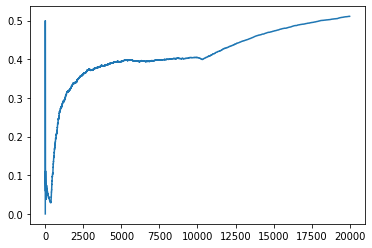

In [22]:
# with learning
plt.plot(range(1,2*num_sims), ctr)

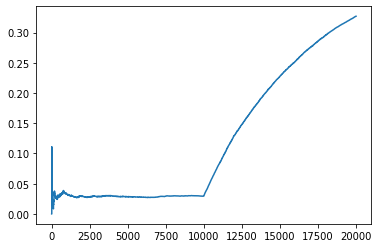

In [25]:
# without learning
# comment vw learn in both for loops
plt.plot(range(1,2*num_sims), ctr)

In [ ]:
# things to do
# (1) change reward function and see how learning happens - DONE (PAVITHRA)
# (2) polish content - good story telling - IN PROGRESS (PAVITHRA)
# (3) add comments - IN PROGRESS (PAVITHRA)
# (4) add plots to see how rewards change per action over time THINKING THROUGH THIS (PAVITHRA)
# (5) Scenario 4: add some noise to reward function
# (6) explain VW example format
# (7) label plots properly
# (8) Summarize results and wrap up story